# Disease gene prioritization

## Contents
* [Load gene and disease network.](#Load-gene-and-disease-network)
* [Load the training data.](#Load-the-training-data.)
* [Define-the-training process.](#Define-the-training-process.)
* [Train the DGP model.](#Train-the-GDP-model.)
* [Eval the results.](#Eval-the-results.)

In [1]:
import sys
import logging
import os
import os.path as osp
import torch
import random
import time
import torch.nn.functional as F
import pandas as pd
from torch.nn import Linear
import numpy as np
from IPython.display import display, HTML
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm
import pickle
import gzip
from livelossplot import PlotLosses

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
##### Expreiment hyperparameters

#  NEGATIVE_SAMPLES determines how the negative examples for training are created.
#  Choose from {'random', 'random_only_disease_gene'}
#    * random: Choose a random (gene, disease) pair which is not in the positive set.
#    * random_only_disease_genes: Like random but gene must be assigned to at least one disease.
NEGATIVE_SAMPLES = 'random'
EXPERIMENT_SLUG = 'final'
device = torch.device('cuda')

## Load gene and disease network

In [3]:
# Load gene and disease network
HERE = osp.abspath('')
ROOT = osp.join(HERE, '..', '..')
DATA_SOURCE_PATH = osp.join(ROOT, 'data_sources')
GENE_DATASET_ROOT = osp.join(DATA_SOURCE_PATH, 'gene_net_fn_hpo')
DISEASE_DATASET_ROOT = osp.join(DATA_SOURCE_PATH, 'disease_net_pubmed_knn')
RESULTS_STORAGE = osp.join(HERE, 'results', EXPERIMENT_SLUG)
MODEL_TMP_STORAGE = osp.join('/', 'var', 'tmp', 'dg_tmp')
sys.path.insert(0, osp.abspath(ROOT))

from GeneNet import GeneNet
from DiseaseNet import DiseaseNet
from TheModel import TheModel

gene_dataset = GeneNet(
    root=GENE_DATASET_ROOT,
    humannet_version='FN',
    features_to_use='hpo',
    skip_truncated_svd=True
)

disease_dataset = DiseaseNet(
    root=DISEASE_DATASET_ROOT,
    hpo_count_freq_cutoff=40,
    edge_source='feature_similarity',
    feature_source='disease_publications',
    skip_truncated_svd=True,
    svd_components=2048,
    svd_n_iter=12
)

Processing...
INFO:root:Generating the gene edges.
INFO:root:Creating the feature vectors.
INFO:root:Creating the feature vectors from `gene_hpo_disease.tsv`


100%|██████████| 77035/77035 [00:00<00:00, 977025.54it/s]

INFO:root:Skipped TruncatedSVD


INFO:root:Storing the data.
INFO:root:Done.
Done!
Processing...
INFO:root:Create disease_id feature_index mapping.
INFO:root:Create feature matrix.
INFO:root:Creating disease feature vectors.
INFO:root:Create publication feature vectors.
INFO:root:Create edges.
INFO:root:Generate similarity based edges.
INFO:root:Storing the data.
INFO:root:Done.
Done!


In [4]:
gene_net_data = gene_dataset[0]
disease_net_data = disease_dataset[0]

# Print topology details.
print(gene_net_data)
print(disease_net_data)

Data(edge_attr=[371502, 1], edge_index=[2, 371502], x=[17247, 6209])
Data(edge_attr=[282464], edge_index=[2, 282464], x=[8827, 11460])


In [5]:
gene_net_data = gene_net_data.to(device)
disease_net_data = disease_net_data.to(device)

## Load the training data.

In [6]:
# Generate training data.
disease_genes = pd.read_table(
    osp.join(DATA_SOURCE_PATH, 'genes_diseases.tsv'),
    names=['EntrezGene ID', 'OMIM ID'],
    sep='\t', 
    low_memory=False, 
    dtype={'EntrezGene ID': pd.Int64Dtype()}
)

disease_id_index_feature_mapping = disease_dataset.load_disease_index_feature_mapping()
gene_id_index_feature_mapping = gene_dataset.load_node_index_mapping()

all_genes = list(gene_id_index_feature_mapping.keys())
all_diseases = list(disease_id_index_feature_mapping.keys())

# 1. generate positive pairs.
# Filter the pairs to only include the ones where the corresponding nodes are available.
# i.e. gene_id should be in all_genes and disease_id should be in all_diseases.
positives = disease_genes[
    disease_genes["OMIM ID"].isin(all_diseases) & disease_genes["EntrezGene ID"].isin(all_genes)
]
covered_diseases = list(set(positives['OMIM ID']))
covered_genes = list(set(positives['EntrezGene ID']))

# 2. Generate negatives.
# Pick equal amount of pairs not in the positives.
negatives_list = []
while len(negatives_list) < len(positives):
    if NEGATIVE_SAMPLES == 'random_only_disease_genes' :
        gene_id = covered_genes[np.random.randint(0, len(covered_genes))]
    else:
        gene_id = all_genes[np.random.randint(0, len(all_genes))]
    disease_id = covered_diseases[np.random.randint(0, len(covered_diseases))]
    if not ((positives['OMIM ID'] == disease_id) & (positives['EntrezGene ID'] == gene_id)).any():
        negatives_list.append([disease_id, gene_id])
negatives = pd.DataFrame(np.array(negatives_list), columns=['OMIM ID', 'EntrezGene ID'])

## Define the training process.

In [7]:
def get_training_data_from_indexes(indexes, monogenetic_disease_only=False, multigenetic_diseases_only=False):
    train_tuples = set()
    for idx in indexes:
        pos = positives[positives['OMIM ID'] == covered_diseases[idx]]
        neg = negatives[negatives['OMIM ID'] == covered_diseases[idx]]
        if monogenetic_disease_only and len(pos) != 1:
            continue
        if multigenetic_diseases_only and len(pos) == 1:
            continue
        for index, row in pos.iterrows():
            train_tuples.add((row['OMIM ID'], row['EntrezGene ID'], 1))
        for index, row in neg.iterrows():
            train_tuples.add((row['OMIM ID'], row['EntrezGene ID'], 0))
    ## 2. Concat data.
    n = len(train_tuples)
    x_out = np.ones((n, 2))  # will contain (gene_idx, disease_idx) tuples.
    y_out = torch.ones((n,), dtype=torch.long)
    for i, (omim_id, gene_id, y) in enumerate(train_tuples):
        x_out[i] = (gene_id_index_feature_mapping[int(gene_id)], disease_id_index_feature_mapping[omim_id])
        y_out[i] = y
    return x_out, y_out

def train(
    max_epochs, 
    early_stopping_window=5, 
    info_each_epoch=1, 
    folds=5, 
    lr=0.0005, 
    weight_decay=5e-4,
    fc_hidden_dim=2048,
    gene_net_hidden_dim=512,
    disease_net_hidden_dim=512
):
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.2, 0.8]).to(device))
    metrics = []
    dis_dict = {}
    fold = 0
    start_time = time.time()
    liveplot = PlotLosses(groups={'training': ['loss', 'val']})
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(covered_diseases):
        fold += 1
        print(f'Generate training data for fold {fold}.')
        all_train_x, all_train_y = get_training_data_from_indexes(train_index)

        # Split into train and validation set.
        id_tr, id_val = train_test_split(range(len(all_train_x)), test_size=0.1, random_state=42)
        train_x = all_train_x[id_tr]
        train_y = all_train_y[id_tr].to(device)
        val_x = all_train_x[id_val]
        val_y = all_train_y[id_val].to(device)

        # Generate the test data for mono and multigenetic diseases.
        ## 1. Collect data.
        print(f'Generate test data for fold {fold}.')
        test_x = dict()
        test_y = dict()
        test_x['mono'], test_y['mono'] = get_training_data_from_indexes(test_index, monogenetic_disease_only=True)
        test_y['mono'] =  test_y['mono'].to(device)
        test_x['multi'], test_y['multi'] = get_training_data_from_indexes(test_index, multigenetic_diseases_only=True)
        test_y['multi'] = test_y['multi'].to(device)

        # Create the model
        model = TheModel(
            gene_feature_dim=gene_net_data.x.shape[1],
            disease_feature_dim=disease_net_data.x.shape[1],
            fc_hidden_dim=fc_hidden_dim,
            gene_net_hidden_dim=gene_net_hidden_dim,
            disease_net_hidden_dim=disease_net_hidden_dim,
            mode='DGP'
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        print(f'Stat training fold {fold}/{folds}:')
        
        losses = dict()
        losses['train'] = list()
        losses['val'] = list()
        
        losses['mono'] = {
                'AUC': 0,
                'TPR': None,
                'FPR': None
        }
        losses['multi'] = {
                'AUC': 0,
                'TPR': None,
                'FPR': None
        }
        
        best_val_loss = 1e80
        for epoch in range(max_epochs):
            # Train model.
            model.train()
            optimizer.zero_grad()
            out = model(gene_net_data, disease_net_data, train_x)
            loss = criterion(out, train_y)
            loss.backward()
            optimizer.step()
            losses['train'].append(loss.item())

            # Validation.
            with torch.no_grad():
                model.eval()
                out = model(gene_net_data, disease_net_data, val_x)
                loss = criterion(out, val_y)
                current_val_loss = loss.item()
                losses['val'].append(current_val_loss)

                if epoch % info_each_epoch == 0:
                    print(
                        'Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
                            epoch, losses['train'][epoch], losses['val'][epoch]
                        )
                    )
                if current_val_loss < best_val_loss:
                    best_val_loss = current_val_loss
                    torch.save(model.state_dict(), osp.join(MODEL_TMP_STORAGE, f'best_model_fold_{fold}.ptm'))
            
            # Early stopping
            if epoch > early_stopping_window:
                # Stop if validation error did not decrease 
                # w.r.t. the past early_stopping_window consecutive epochs.
                last_window_losses = losses['val'][epoch - early_stopping_window:epoch]
                if losses['val'][-1] > max(last_window_losses):
                    print('Early Stopping!')
                    break

        # Test the model for the current fold.
        model.load_state_dict(torch.load(osp.join(MODEL_TMP_STORAGE, f'best_model_fold_{fold}.ptm')))
        with torch.no_grad():
            for modus in ['multi', 'mono']:
                predicted_probs = F.log_softmax(
                    model(gene_net_data, disease_net_data, test_x[modus]).clone().detach(), dim=1
                )
                true_y = test_y[modus]
                fpr, tpr, _ = roc_curve(true_y.cpu().detach().numpy(), predicted_probs[:,1].cpu().detach().numpy(), pos_label=1)
                roc_auc = auc(fpr, tpr)
                losses[modus]['TEST_Y'] = true_y.cpu().detach().numpy()
                losses[modus]['TEST_PREDICT'] = predicted_probs.cpu().numpy()
                losses[modus]['AUC'] = roc_auc
                losses[modus]['TPR'] = tpr
                losses[modus]['FPR'] = fpr
                print(f'"{modus}" auc for fold: {fold}: {roc_auc}')            
        metrics.append(losses)

    print('Done!')
    return metrics, dis_dict, model

In [8]:
# Define helpers for evaluation
def negcum(rank_vec):
    rank_vec_cum = []
    prev = 0
    for x in rank_vec:
        if x == 0:
            prev += 1
            rank_vec_cum.append(prev)
        else:
            rank_vec_cum.append(prev)
    rank_vec_cum = np.array(rank_vec_cum)
    return rank_vec_cum

disease_idx_to_omim_mapping = dict()
for omim_id, disease_idx in disease_id_index_feature_mapping.items():
    disease_idx_to_omim_mapping[disease_idx] = omim_id

gene_idx_entrez_id_mapping = dict()
for entrez_id, gene_idx in gene_id_index_feature_mapping.items():
    gene_idx_entrez_id_mapping[gene_idx] = entrez_id

def get_genes_assoc_to_omim_disease(omim_id):
    return positives[positives["OMIM ID"].isin([omim_id])]["EntrezGene ID"].values

## Train the GDP model.
* Store trained models in `best_model_fold_{fold}.ptm`
* Store results in `{EXPERIMENT_SLUG}_metrics.pickle.gz` and `{EXPERIMENT_SLUG}_dis_dict.pickle.gz`

In [9]:
torch.set_num_threads=16

# Reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

fc_hidden_dim = 3000
gene_net_hidden_dim = 830
disease_net_hidden_dim = 500
folds = 5
max_epochs = 500 
early_stopping_window = 16
lr = 0.00004
weight_decay = 0.15

metrics, dis_dict, model = train(
    max_epochs=max_epochs, 
    early_stopping_window=early_stopping_window,
    folds=folds, 
    lr=lr,
    weight_decay=weight_decay,
    fc_hidden_dim=fc_hidden_dim,
    gene_net_hidden_dim=gene_net_hidden_dim,
    disease_net_hidden_dim=disease_net_hidden_dim
)

# Store the results.
if not os.path.exists(RESULTS_STORAGE):
    os.makedirs(RESULTS_STORAGE)
with gzip.open(osp.join(RESULTS_STORAGE, f'{EXPERIMENT_SLUG}_metrics.pickle.gz'), mode='wb') as file:
    pickle.dump(metrics, file)
with gzip.open(osp.join(RESULTS_STORAGE, f'{EXPERIMENT_SLUG}_dis_dict.pickle.gz'), mode='wb') as file:
    pickle.dump(dis_dict, file)

Generate training data for fold 1.
Generate test data for fold 1.
Stat training fold 1/5:
Epoch 0, train_loss: 0.7132, val_loss: 0.6790
Epoch 1, train_loss: 0.6892, val_loss: 0.6761
Epoch 2, train_loss: 0.6698, val_loss: 0.6735
Epoch 3, train_loss: 0.6533, val_loss: 0.6710
Epoch 4, train_loss: 0.6382, val_loss: 0.6685
Epoch 5, train_loss: 0.6254, val_loss: 0.6661
Epoch 6, train_loss: 0.6138, val_loss: 0.6638
Epoch 7, train_loss: 0.6029, val_loss: 0.6616
Epoch 8, train_loss: 0.5933, val_loss: 0.6594
Epoch 9, train_loss: 0.5856, val_loss: 0.6573
Epoch 10, train_loss: 0.5777, val_loss: 0.6553
Epoch 11, train_loss: 0.5710, val_loss: 0.6533
Epoch 12, train_loss: 0.5645, val_loss: 0.6514
Epoch 13, train_loss: 0.5580, val_loss: 0.6495
Epoch 14, train_loss: 0.5536, val_loss: 0.6477
Epoch 15, train_loss: 0.5483, val_loss: 0.6459
Epoch 16, train_loss: 0.5432, val_loss: 0.6442
Epoch 17, train_loss: 0.5397, val_loss: 0.6425
Epoch 18, train_loss: 0.5349, val_loss: 0.6408
Epoch 19, train_loss: 0.532

Epoch 172, train_loss: 0.3553, val_loss: 0.3804
Epoch 173, train_loss: 0.3549, val_loss: 0.3795
Epoch 174, train_loss: 0.3542, val_loss: 0.3787
Epoch 175, train_loss: 0.3536, val_loss: 0.3779
Epoch 176, train_loss: 0.3522, val_loss: 0.3771
Epoch 177, train_loss: 0.3520, val_loss: 0.3764
Epoch 178, train_loss: 0.3511, val_loss: 0.3757
Epoch 179, train_loss: 0.3504, val_loss: 0.3750
Epoch 180, train_loss: 0.3497, val_loss: 0.3743
Epoch 181, train_loss: 0.3487, val_loss: 0.3736
Epoch 182, train_loss: 0.3486, val_loss: 0.3728
Epoch 183, train_loss: 0.3475, val_loss: 0.3721
Epoch 184, train_loss: 0.3462, val_loss: 0.3713
Epoch 185, train_loss: 0.3463, val_loss: 0.3706
Epoch 186, train_loss: 0.3449, val_loss: 0.3699
Epoch 187, train_loss: 0.3445, val_loss: 0.3693
Epoch 188, train_loss: 0.3442, val_loss: 0.3686
Epoch 189, train_loss: 0.3428, val_loss: 0.3679
Epoch 190, train_loss: 0.3424, val_loss: 0.3672
Epoch 191, train_loss: 0.3416, val_loss: 0.3664
Epoch 192, train_loss: 0.3410, val_loss:

Epoch 343, train_loss: 0.2775, val_loss: 0.3153
Epoch 344, train_loss: 0.2774, val_loss: 0.3165
Epoch 345, train_loss: 0.2772, val_loss: 0.3161
Epoch 346, train_loss: 0.2768, val_loss: 0.3154
Epoch 347, train_loss: 0.2768, val_loss: 0.3141
Epoch 348, train_loss: 0.2762, val_loss: 0.3141
Epoch 349, train_loss: 0.2763, val_loss: 0.3144
Epoch 350, train_loss: 0.2762, val_loss: 0.3149
Epoch 351, train_loss: 0.2762, val_loss: 0.3146
Epoch 352, train_loss: 0.2756, val_loss: 0.3142
Epoch 353, train_loss: 0.2756, val_loss: 0.3145
Epoch 354, train_loss: 0.2755, val_loss: 0.3148
Epoch 355, train_loss: 0.2755, val_loss: 0.3143
Epoch 356, train_loss: 0.2748, val_loss: 0.3142
Epoch 357, train_loss: 0.2748, val_loss: 0.3145
Epoch 358, train_loss: 0.2744, val_loss: 0.3133
Epoch 359, train_loss: 0.2745, val_loss: 0.3136
Epoch 360, train_loss: 0.2741, val_loss: 0.3139
Epoch 361, train_loss: 0.2745, val_loss: 0.3143
Epoch 362, train_loss: 0.2739, val_loss: 0.3147
Epoch 363, train_loss: 0.2739, val_loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# Store the model for later use in disease class prediction.
from shutil import copyfile
for i in range(1, folds + 1):
    copyfile(
        osp.join(MODEL_TMP_STORAGE, f'best_model_fold_{i}.ptm'),
        osp.join(RESULTS_STORAGE, f'model_fold_{i}.ptm')
    )

## Eval the results.
* Load the results.
* Compute the ROC for each fold and combined. Distinguish by mono and multigenic diseases.

In [11]:
# Load the results
with gzip.open(osp.join(RESULTS_STORAGE, f'{EXPERIMENT_SLUG}_metrics.pickle.gz'), mode='rb') as file:
    metrics = pickle.load(file, encoding='bytes')
with gzip.open(osp.join(RESULTS_STORAGE, f'{EXPERIMENT_SLUG}_dis_dict.pickle.gz'), mode='rb') as file:
    dis_dict = pickle.load(file, encoding='bytes')

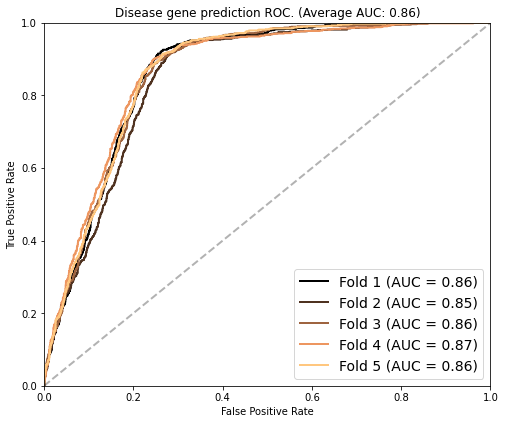

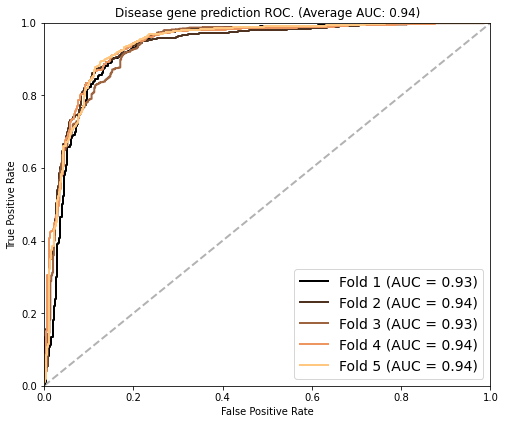

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc


def plot_folds_roc(disease_gene_type):
    average_roc = sum([m[disease_gene_type]['AUC'] for m in metrics])/len(metrics)
    colors = iter(plt.cm.copper(np.linspace(0, 1, len(metrics))))
    plt.figure(figsize=(8, 8))
    labels, lines = [], []

    for i, color in zip(range(len(metrics)), colors):
        l, = plt.plot(metrics[i][disease_gene_type]['FPR'], metrics[i][disease_gene_type]['TPR'], color=color, lw=2)
        lines.append(l)
        auc_val = metrics[i][disease_gene_type]['AUC']
        labels.append(f'Fold {i + 1} (AUC = {auc_val:0.2f})')

    l, = plt.plot([0, 1], [0, 1], color=[0, 0, 0, 0.3], lw=2, linestyle='--')
    lines.append(l)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Disease gene prediction ROC. (Average AUC: {average_roc:0.2f})')
    plt.legend(lines, labels, loc=(0.56, 0.02), prop=dict(size=14))

    fig.savefig(
        osp.join(RESULTS_STORAGE, f"Disease_gene_prediction_ROC_by_fold_{disease_gene_type}genic_diseases.pdf"),
        bbox_inches='tight'
    )
    plt.show()

plot_folds_roc('mono')
plot_folds_roc('multi')

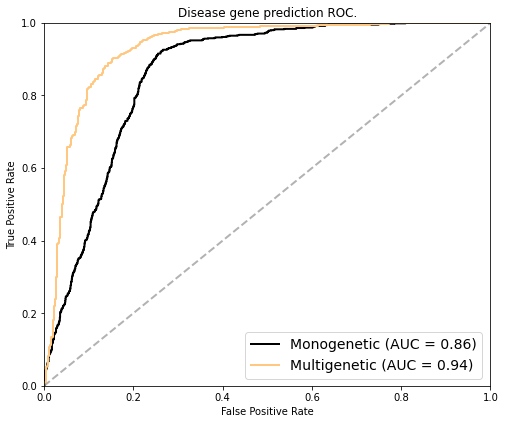

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

colors = iter(plt.cm.copper(np.linspace(0, 1, 2)))
plt.figure(figsize=(8, 8))
labels, lines = [], []

# Average FPR and TPR over the folds.
avg_metrics = {
    'mono': [],
    'multi': []
}

for mode, color in zip(avg_metrics.keys(), colors):
    t_pred_tmp = metrics[0][mode]['TEST_PREDICT'].copy()
    t_pos_tmp = metrics[0][mode]['TEST_Y'].copy()
    for i in range(len(metrics)):
        t_pred_tmp = np.concatenate((t_pred_tmp, metrics[0][mode]['TEST_PREDICT'].copy()), axis=0)
        t_pos_tmp = np.concatenate((t_pos_tmp, metrics[0][mode]['TEST_Y'].copy()), axis=0)
    
    fpr, tpr, _ = roc_curve(t_pos_tmp, t_pred_tmp[:,1], pos_label=1)
    average_roc = sum([m[mode]['AUC'] for m in metrics])/len(metrics)
    
    l, = plt.plot(fpr, tpr, color=color, lw=2)
    lines.append(l)
    labels.append(f'M{mode[1:]}genetic (AUC = {average_roc:0.2f})')

l, = plt.plot([0, 1], [0, 1], color=[0, 0, 0, 0.3], lw=2, linestyle='--')
lines.append(l)

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Disease gene prediction ROC.')
plt.legend(lines, labels, loc=(0.45, 0.02), prop=dict(size=14))

fig.savefig(
    osp.join(RESULTS_STORAGE, "Disease_gene_prediction_ROC_combined.pdf"),
    bbox_inches='tight'
)
plt.show()